In [1]:
import numpy as np
import scipy as sp
import h5py
import pandas as pd
import os
import glob
import importlib
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from utils.Surf import roi2gii, vertex2gii
import utils.Vis
importlib.reload(utils.Vis)
from utils.Vis import plot_maps

In [2]:
# Config parameters
root = "/home/ali/graham-akhanf/EpLink/Eplink"
results_path = os.path.join(root,"ISC-pipeline","results","{dataset}","looISC","control")
atlases_path = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K')

atlases = ['none', 'Glasser_2016', 'Desikan', 'Schaefer2018_17Networks_400', 'Yan2023_17Networks_400']
atlases_aliases = ['Vertex', 'Glasser 2016', 'Desikan', 'Schaefer 2018', 'Yan 2023']

datasets = ["eplink-p2", "eplink-p3"]
task_dataset = {'eplink-p2': 'hitchcock', 'eplink-p3': 'movie'}
resampled_dataset = {'eplink-p2': 'N', 'eplink-p3': 'Y'}

fwhm = 0
confounds_idx = 1

file_pattern = "looISC_task-{task}_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_resampled-{resampled}_atlas-{atlas}.h5"

In [3]:
def load_data_loo(file_format):
    data = dict()
    for h in ['L', 'R']:
        fpath = file_format.format(hemi=h)
        with h5py.File(fpath, 'r') as f:
                # Load the pairwise ISCs
                data[h] = f['loo_ISC'][:]
    return data

In [61]:
# Load atlas labels

atlas_labels = dict()

for atlas in atlases[1:]:
    atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
    labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
    labels_list_L = [None] * len(labels)
    for k,v in labels.items():
        labels_list_L[k] = v
    labels = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
    labels_list_R = [None] * len(labels)
    for k,v in labels.items():
        labels_list_R[k] = v
    
    atlas_labels[atlas] = labels_list_L + labels_list_R

atlas_labels['Desikan'].remove('corpuscallosum')
atlas_labels['Desikan'].remove('corpuscallosum')

atlas_labels['Yan2023_17Networks_400'] = atlas_labels['Yan2023_17Networks_400'][:402]
atlas_labels['Yan2023_17Networks_400'][201:] = atlas_labels['Yan2023_17Networks_400'][200:401]
atlas_labels['Yan2023_17Networks_400'][200] = atlas_labels['Yan2023_17Networks_400'][0]

# Generate leave-one-out mean maps

In [8]:
mean_ISC = dict()
all_ISC = dict()
for dataset in datasets:
    task = task_dataset[dataset]
    for i, atlas in enumerate(atlases):
        file_format = os.path.join(results_path, file_pattern).format(dataset=dataset, task=task, fwhm=fwhm, confounds_idx=confounds_idx, resampled = 'N', atlas=atlas)
        ISC = load_data_loo(file_format)

        ISC_mean = {k: v.mean(axis=0) for k,v in ISC.items()}
        mean_ISC[f'{dataset}-{atlas}'] = np.concatenate([ISC_mean['L'], ISC_mean['R']])
        all_ISC[f'{dataset}-{atlas}'] = np.concatenate([ISC['L'], ISC['R']], axis=1) 

        output_path = os.path.join('.','surface_maps',f'{dataset}')
        if atlas == 'none':
            vertex2gii(ISC_mean, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
        else:
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
            roi2gii(ISC_mean, atlasfile, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

# Generate leave-one-out cov maps

In [11]:
cv = dict()
for dataset in datasets:
    task = task_dataset[dataset]
    for i, atlas in enumerate(atlases):
        file_format = os.path.join(results_path, file_pattern).format(dataset=dataset, task=task, fwhm=fwhm, confounds_idx=confounds_idx, resampled = 'N', atlas=atlas)
        ISC = load_data_loo(file_format)

        ISC_cv = {k: np.log(np.abs(v.std(axis=0)/v.mean(axis=0))) for k,v in ISC.items()}
        cv[f'{dataset}-{atlas}'] = np.concatenate([ISC_cv['L'], ISC_cv['R']]) 

        output_path = os.path.join('.','surface_maps',f'{dataset}')
        if atlas == 'none':
            vertex2gii(ISC_cv, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
        else:
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
            roi2gii(ISC_cv, atlasfile, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

# Figure

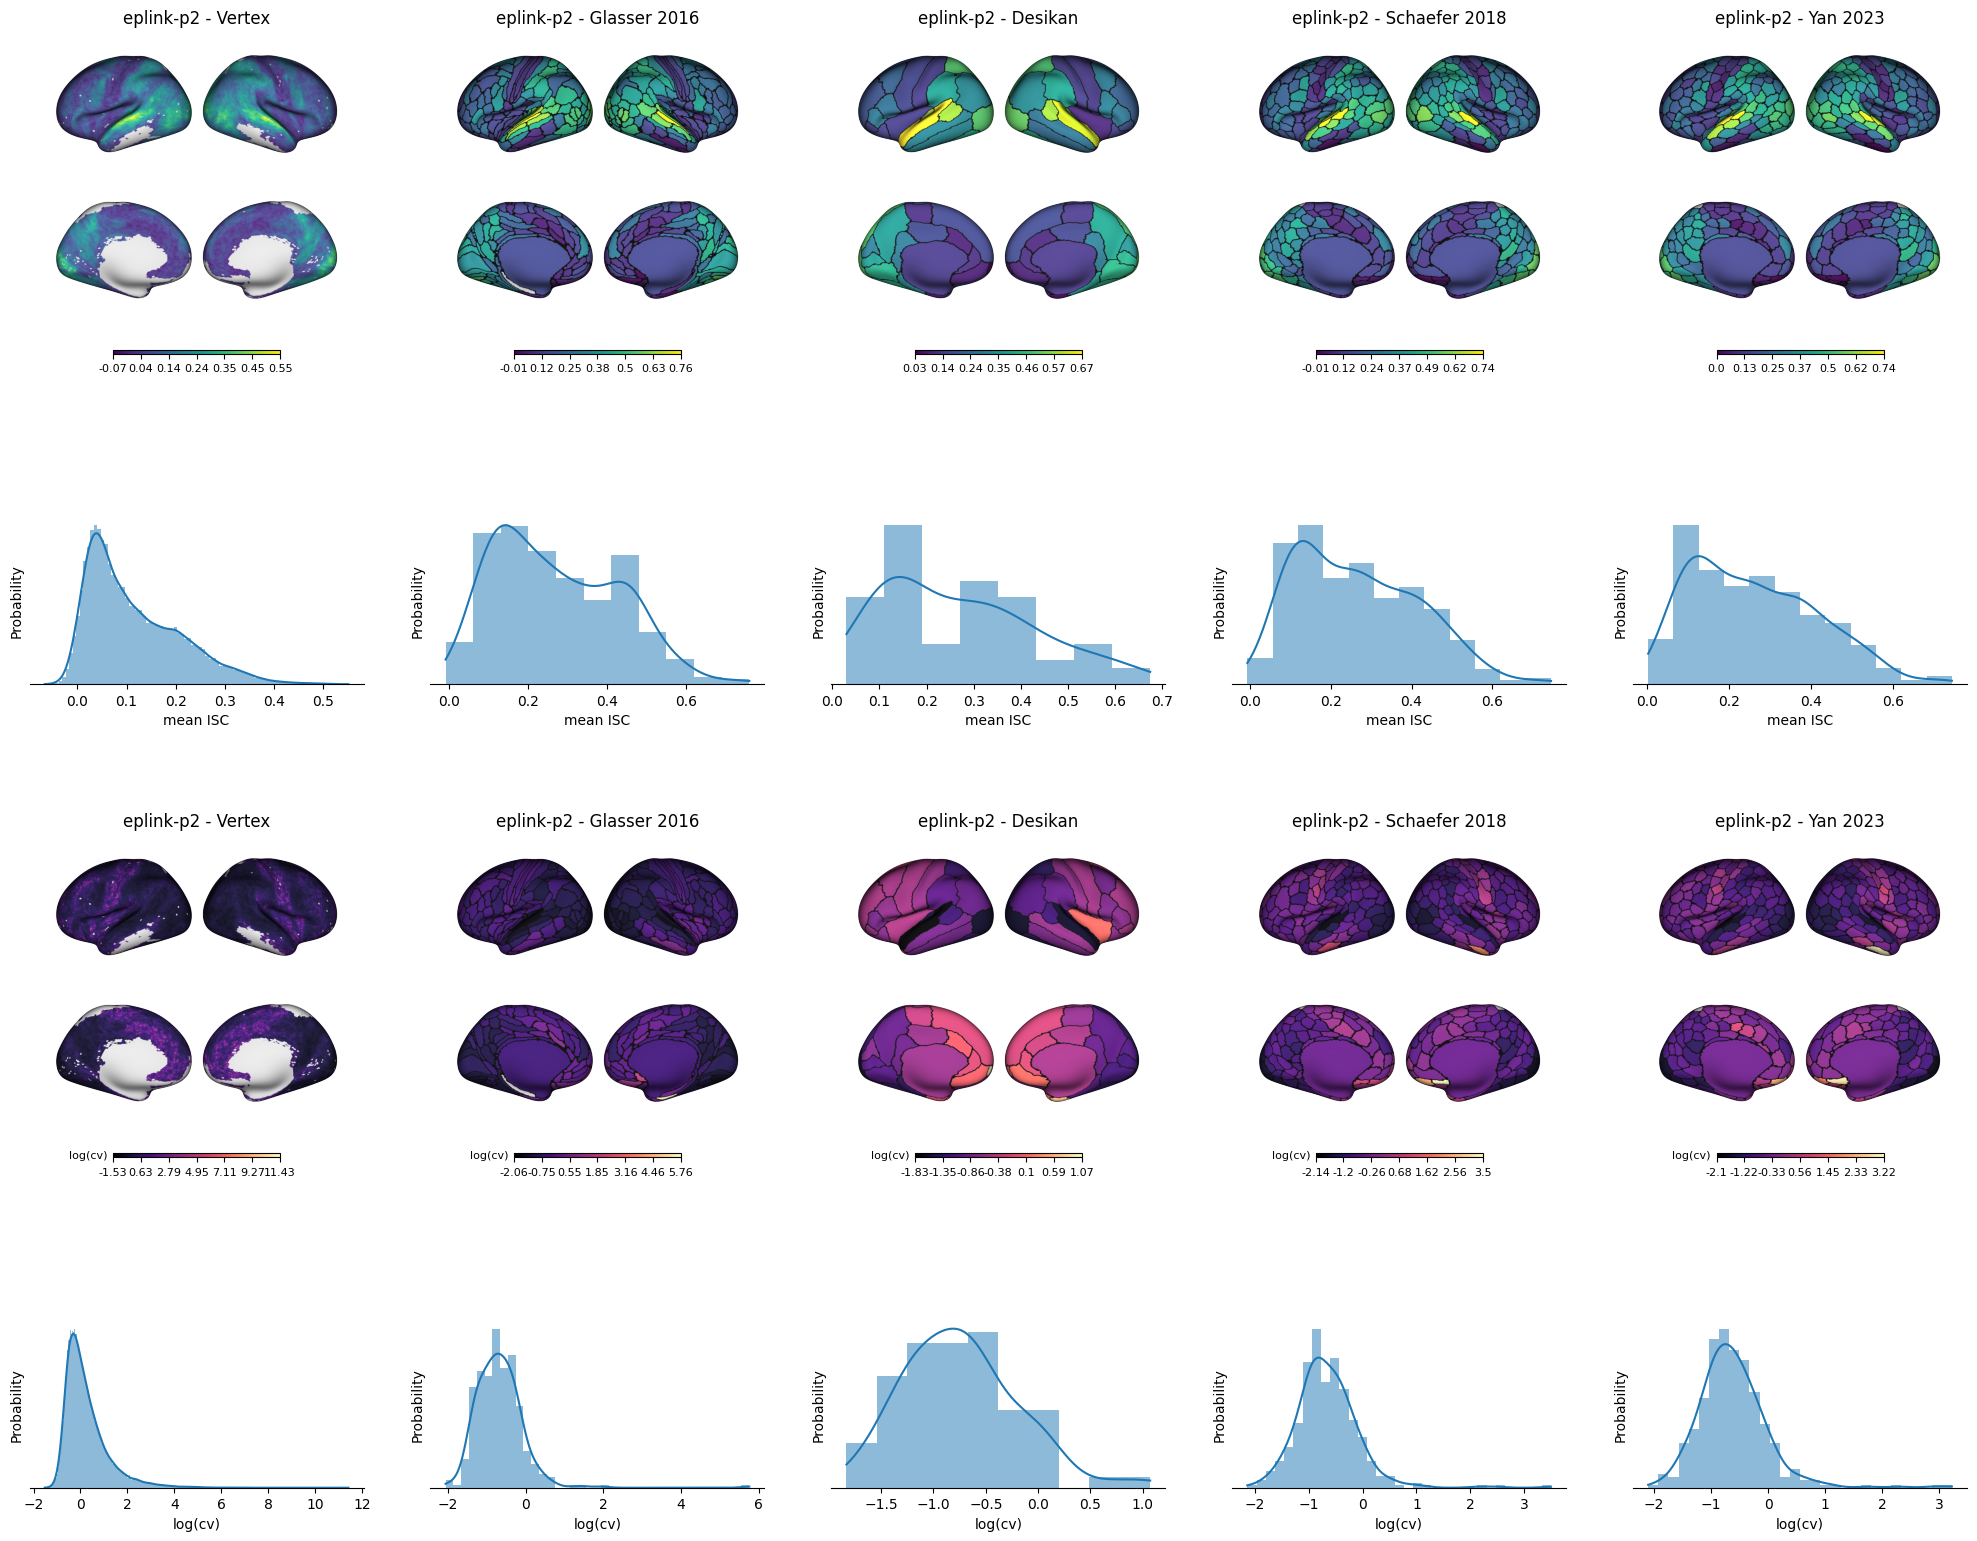

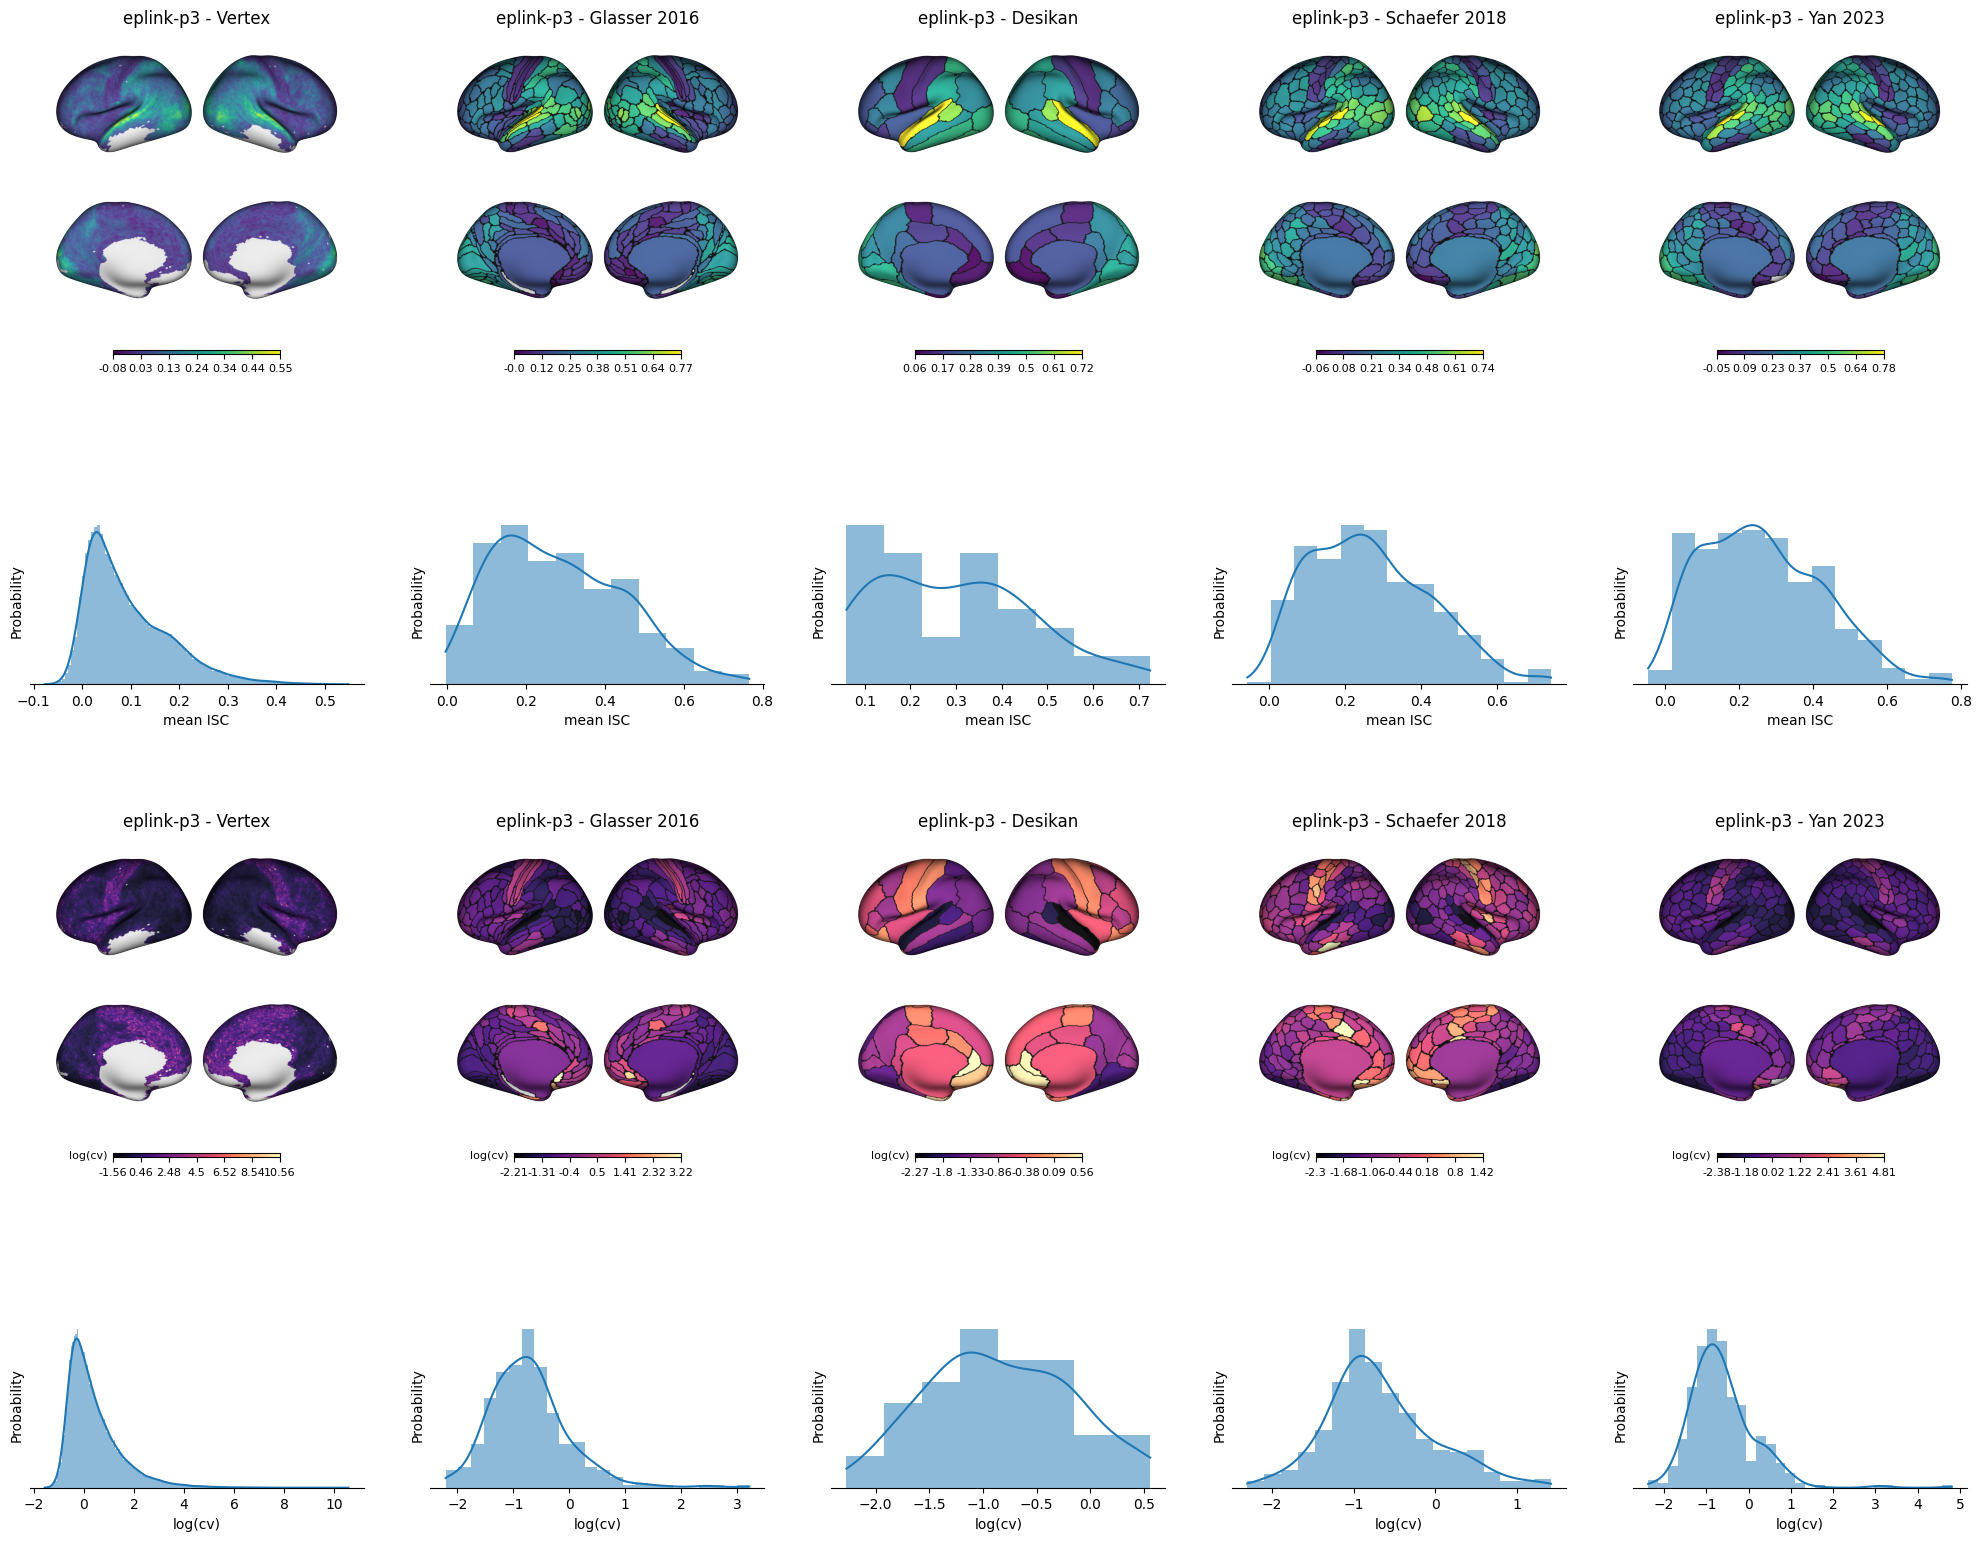

In [13]:
importlib.reload(utils.Vis)
from utils.Vis import plot_maps
for dataset in datasets:
    fig, axes = plt.subplots(4,5,figsize=(25,20))
    # plot ISC mean maps
    for i, atlas in enumerate(atlases):
        if atlas != 'none':
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        else:
            atlasfile = None
        map_path = os.path.join('.','surface_maps',f'{dataset}',f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
        plot_maps(map_path, atlas=atlasfile, title=f'{dataset} - {atlases_aliases[i]}', ax=axes[0,i])
    # plot ISC mean histogram
    for i, atlas in enumerate(atlases):        
        ax = axes[1,i]

        sns.histplot(mean_ISC[f'{dataset}-{atlas}'], ec='None', stat='probability', kde=True, ax=ax)

        ax.set_box_aspect(0.5)
        # axes[3,i].set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('mean ISC')
        ax.set_yticks([])

    # plot ISC cv maps
    for i, atlas in enumerate(atlases):
        if atlas != 'none':
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        else:
            atlasfile = None
        map_path = os.path.join('.','surface_maps',f'{dataset}',f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
        plot_maps(map_path, atlas=atlasfile, cmap='magma', title=f'{dataset} - {atlases_aliases[i]}', clabel='log(cv)', ax=axes[2,i])
    # plot ISC cv histogram
    for i, atlas in enumerate(atlases):
        # if atlas == 'none': 
        #     continue
        ax = axes[3,i]
        sns.histplot(cv[f'{dataset}-{atlas}'], ec='None', stat='probability', kde=True, ax=ax)
        ax.set_box_aspect(0.5)
        # axes[3,i].set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('log(cv)')
        ax.set_yticks([])
    

In [ ]:
# histogram of roi sizes
# flip color for cv

# ROIs with lowest cv

eplink-p2
['L_A5_ROI', 'R_A5_ROI', 'L_A4_ROI', 'R_V4_ROI', 'L_STSda_ROI']
['superiortemporal', 'superiortemporal', 'lateraloccipital', 'lateraloccipital', 'transversetemporal']
['17networks_LH_Aud_ST_5', '17networks_RH_VisualB_Striate_3', '17networks_LH_Aud_ST_4', '17networks_RH_Aud_ST_5', '17networks_LH_VisualB_Striate_3']
eplink-p3
['L_A4_ROI', 'R_A5_ROI', 'R_PBelt_ROI', 'L_PBelt_ROI', 'L_A5_ROI']
['superiortemporal', 'superiortemporal', 'bankssts', 'transversetemporal', 'inferiortemporal']
['17networks_LH_Aud_ST_5', '17networks_RH_Aud_ST_5', '17networks_RH_Aud_ST_4', '17networks_RH_Aud_ST_2', '17networks_RH_Aud_ST_1']


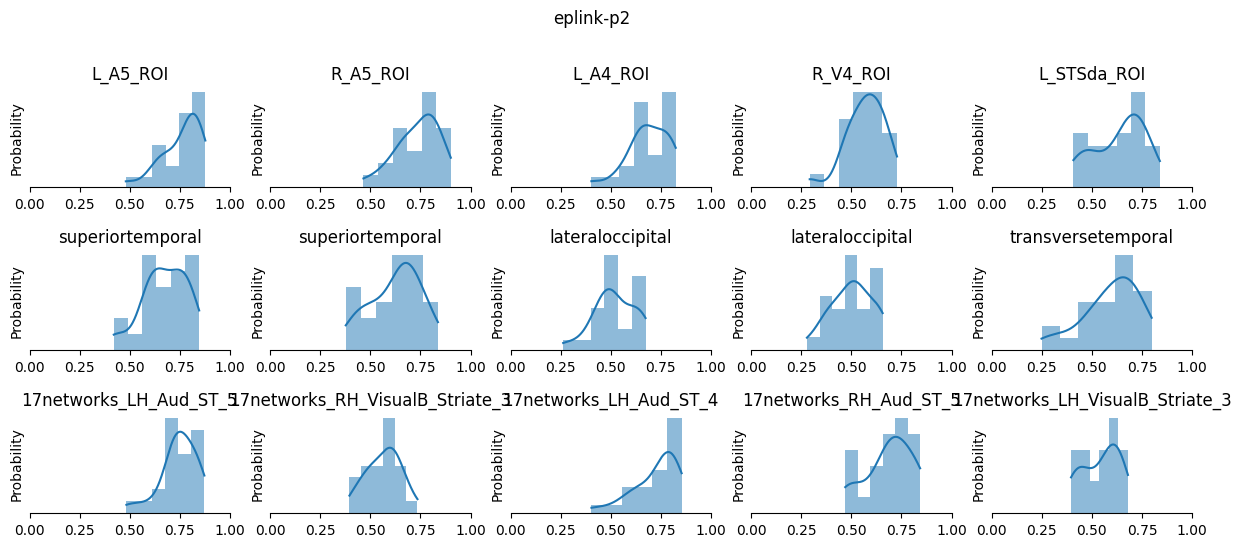

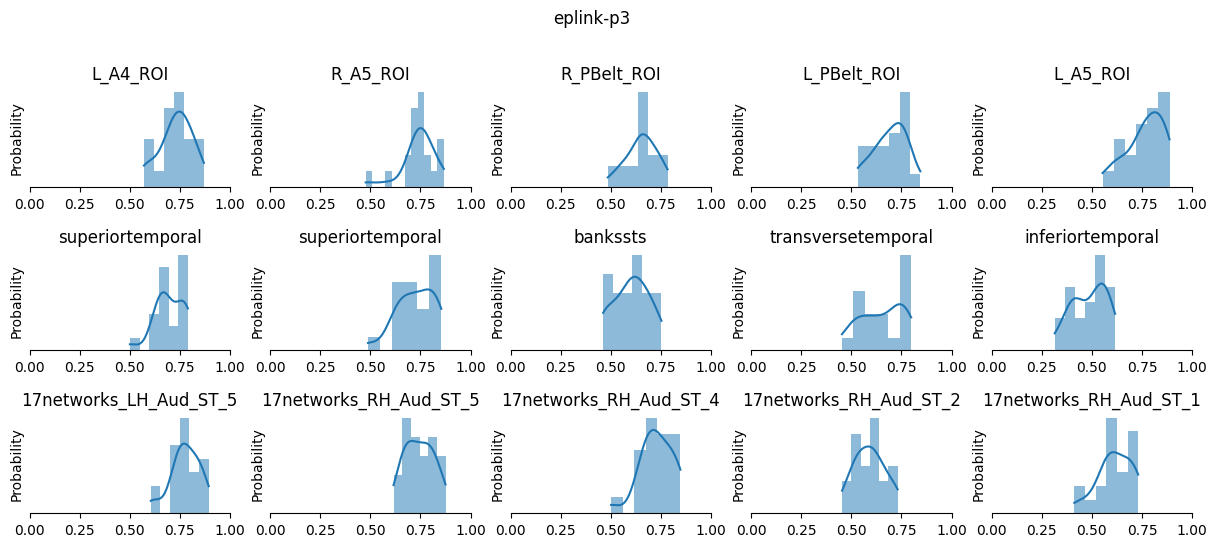

In [120]:
for dataset in datasets:
    print(dataset)
    fig, axes = plt.subplots(len(atlases)-1,5,figsize=(15,6))
    for i, atlas in enumerate(atlases[1:]):
        # Load labels
        atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
        labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
        labels_R = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
        n_rois = len(labels)
        for r in range(n_rois):
            labels[r+n_rois] = labels_R[r]

        # ind = np.nanargmin(cv[f'{dataset}-{atlas}'])
        # print(f'{atlas}: {labels[ind]}')

        ind = np.argsort(cv[f'{dataset}-{atlas}'])
        print([labels[l] for l in ind[:5]])

        for s in range(5):
            ax = axes[i,s]
            sns.histplot(all_ISC[f'{dataset}-{atlas}'][:,ind[s]], stat='probability', ec=None, kde=True, ax=ax)
            # Turn off the box (frame) around the plot
            ax.set_title(labels[ind[s]])
            ax.set_box_aspect(0.5)
            ax.set_xlim(0,1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # axes[s].spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])

    fig.suptitle(f'{dataset}')

In [5]:
# Helper functions
def get_dimensions(filepath):
    """Extract dimensions of data from h5 data."""
    # Check file extension
    ext = os.path.splitext(filepath)[-1]
    
    # h5 file
    if ext == '.h5': 
        # Open the HDF5 file
        with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            # Return data dimensions
            n_rois, n_vol = data.shape
    
    # gii file
    elif ext == '.gii':
        # Load the GIFTI file by nibabel
        gii = nib.load(filepath)
        # Return data dimensions
        n_rois = gii.darrays[0].data.shape[0]
        n_vol = len(gii.darrays)
    
    return n_rois, n_vol

def load_HDF(filepath, n_vols):
    """Load data stored in the HDF files given the runs dataframe."""
    with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            data = data[:,:n_vols] # Ignoring excessive volumes
    # Returns data with shape ROI x Time
    return data

def load_gii(filepath, n_vols):
    func_gii = nib.load(filepath)
    data = np.vstack([darray.data for darray in func_gii.darrays[:n_vols]]).T
    # Returns data with shape Vertex x Time
    return data

def load_runs(runs_df, n_vols):
    # Loading only the last run
    fp = runs_df['full_path'].iloc[-1]
    # Checking file extension
    ext = os.path.splitext(fp)[-1]

    # h5 file
    if ext == '.h5':
        data = load_HDF(fp, n_vols)
    # gii file
    elif ext == '.gii':
        data = load_gii(fp, n_vols)
    
    return data

def get_info(filepath):
    """Extract subject, hemi, task, run, fwhm, confounds,
      rois, and number of volumes from a given file."""
    # Get file name
    basename = os.path.basename(filepath)
    # Split file name by '_'
    parts = basename.split('_')
    # Info dictionary
    info = {}
    # Parse file name
    for part in parts:
        info['full_path'] = filepath

        if part.startswith('sub-'):
            info['subject'] = part.split('sub-')[1]
        elif part.startswith('hemi-'):
            info['hemi'] = part.split('hemi-')[1]
        elif part.startswith('task-'):
            info['task'] = part.split('task-')[1]
        elif part.startswith('run-'):
            info['run'] = part.split('run-')[1]
        elif part.startswith('fwhm-'):
            info['fwhm'] = part.split('fwhm-')[1]
        elif part.startswith('confounds-'):
            info['confounds'] = part.split('confounds-')[1].split('_')[0]  # Assuming confounds is the last part before the file extension

    # Get dimensions for stored data    
    info['n_roi'], info['n_vol'] = get_dimensions(filepath)
    
    return info

def build_dataframe(directory, pattern=None):
    """Build a dataframe from files in the directory and its subdirectories."""
    # Default Pattern for search
    if pattern == None:
        subject, hemi, task, run, fwhm, confounds = ('*', '*', '*', '*', 0, 1)
        pattern = f"sub-{subject}_hemi-{hemi}_task-{task}_run-{run}_space-fsLR_den-32k_desc-denoised_fwhm-{fwhm}_confounds-{confounds}_atlas-glasser.h5"
    
    pattern = os.path.join(directory, 'sub-*', 'func', pattern)
    # Get all files matching the pattern
    files = glob.glob(pattern, recursive=True)
    # Building the dataframe
    df = pd.DataFrame([get_info(file) for file in files])
    
    return df

In [174]:
dataset = 'eplink-p2'
data_path = os.path.join(root, 'ISC-pipeline', 'results', f'{dataset}', 'resampled2fsLR', '32k_space_surfaces-parcellated', f'{atlases[1]}')
subjects_path = glob.glob(os.path.join(data_path, 'sub-*'))
subjects = [int(os.path.basename(p)[4:]) for p in subjects_path]
subjects.sort()

subject, hemi, task, run, fwhm, confounds = ('*', '*', task_dataset[dataset], '*', 0, 1)
datafile_pattern = f"sub-{subject}_task-{task}_run-{run}_hemi-{hemi}_confounds-{confounds}_bold.func.h5"

df = build_dataframe(data_path, datafile_pattern)
# Sort files 
df = df.sort_values(by=['subject', 'task', 'run'], ascending=[True]*3).reset_index()
# Ignore some columns
#['subject', 'task', 'run', 'hemi', 'fwhm', 'confounds', 'n_vol', 'full_path']
df = df[['subject', 'task', 'run', 'hemi', 'n_vol', 'full_path']]
print(df)

   subject       task run hemi  n_vol  \
0     0068  hitchcock   1    L    246   
1     0068  hitchcock   1    R    246   
2     0069  hitchcock   1    R     12   
3     0069  hitchcock   1    L     12   
4     0069  hitchcock   2    R    246   
..     ...        ...  ..  ...    ...   
85    5105  hitchcock   1    L     24   
86    5105  hitchcock   2    L    246   
87    5105  hitchcock   2    R    246   
88    5106  hitchcock   1    L    246   
89    5106  hitchcock   1    R    246   

                                            full_path  
0   /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
1   /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
2   /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
3   /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
4   /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
..                                                ...  
85  /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
86  /home/ali/graham-akhanf/EpLink/Eplink/ISC-pipe...  
87 

In [175]:
target_volumes = 240# 384
# Exclude files with less volumes
df = df[df["n_vol"] >= target_volumes].reset_index(drop=True)
# Get unique subjects
subjects = df['subject'].unique()
controls = [s for s in subjects if int(s) > 5000]
patients = [s for s in subjects if int(s) < 5000]
n_subject = len(subjects)

In [176]:
# Load files data
data = []
for subj in controls:
    # Filter subject files 
    df_s = df[df['subject'] == subj]
    # Load runs
    data.append(load_runs(df_s, target_volumes))

# Stacking subjects data (Subject, Unit, Time)
data = np.stack(data)

In [55]:
all_ISC[f'{datasets[1]}-{atlases[1]}'][:,9]


array([ 0.10625188,  0.06400174,  0.18646492,  0.32577434,  0.19577396,
        0.01164593,  0.11901104,  0.09861618,  0.11293228, -0.00142835,
       -0.01882902, -0.09194881,  0.11883532,  0.03110944, -0.01975281])

# Combined phases

In [8]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"

mean_ISC = dict()
all_ISC = dict()

for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC = load_data_loo(file_format)

    ISC_mean = {k: v.mean(axis=0) for k,v in ISC.items()}
    mean_ISC[f'{atlas}'] = np.concatenate([ISC_mean['L'], ISC_mean['R']])
    all_ISC[f'{atlas}'] = np.concatenate([ISC['L'], ISC['R']], axis=1) 

    output_path = os.path.join('.','surface_maps','phases_combined')
    if atlas == 'none':
        print('!')# vertex2gii(ISC_mean, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
    else:
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        roi2gii(ISC_mean, atlasfile, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

In [9]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"

cv = dict()
for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC = load_data_loo(file_format)

    ISC_cv = {k: np.log(np.abs(v.std(axis=0)/v.mean(axis=0))) for k,v in ISC.items()}
    cv[f'{atlas}'] = np.concatenate([ISC_cv['L'], ISC_cv['R']]) 

    output_path = os.path.join('.','surface_maps','phases_combined')
    if atlas == 'none':
        vertex2gii(ISC_cv, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
    else:
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        roi2gii(ISC_cv, atlasfile, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

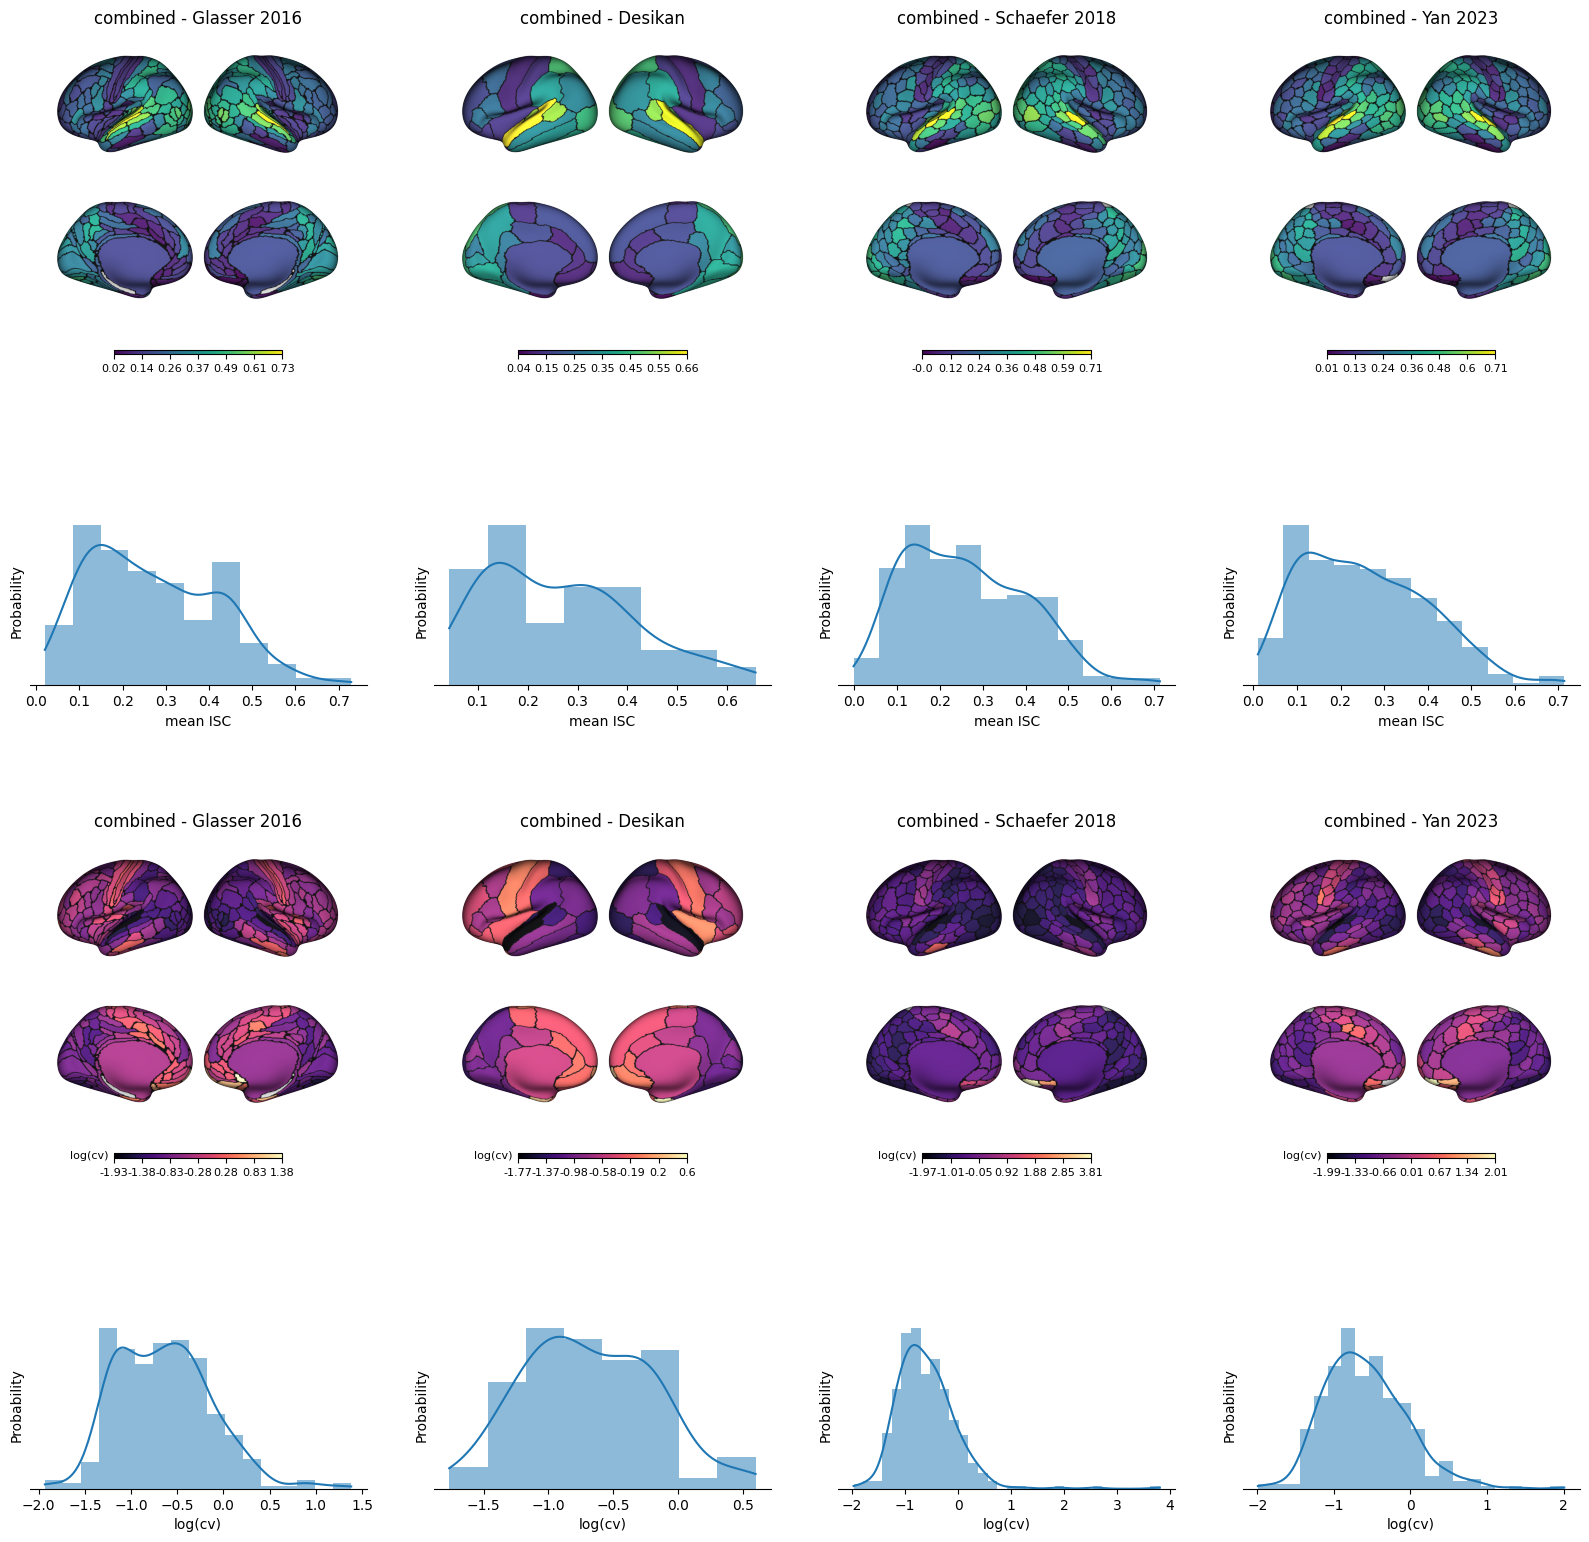

In [11]:
importlib.reload(utils.Vis)
from utils.Vis import plot_maps
fig, axes = plt.subplots(4,4,figsize=(20,20))
# plot ISC mean maps
for i, atlas in enumerate(atlases[1:]):
    if atlas != 'none':
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('.','surface_maps','phases_combined',f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, atlas=atlasfile, title=f'combined - {atlases_aliases[i+1]}', ax=axes[0,i])
# plot ISC mean histogram
for i, atlas in enumerate(atlases[1:]):        
    ax = axes[1,i]

    sns.histplot(mean_ISC[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)

    ax.set_box_aspect(0.5)
    # axes[3,i].set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # axes[s].spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('mean ISC')
    ax.set_yticks([])

# plot ISC cv maps
for i, atlas in enumerate(atlases[1:]):
    if atlas != 'none':
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('.','surface_maps','phases_combined',f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, atlas=atlasfile, cmap='magma', title=f'combined - {atlases_aliases[i+1]}', clabel='log(cv)', ax=axes[2,i])
# plot ISC cv histogram
for i, atlas in enumerate(atlases[1:]):
    # if atlas == 'none': 
    #     continue
    ax = axes[3,i]
    sns.histplot(cv[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)
    ax.set_box_aspect(0.5)
    # axes[3,i].set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # axes[s].spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('log(cv)')
    ax.set_yticks([])


In [14]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_patients.h5"

patients_ISC = dict()
for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC_p = load_data_loo(file_format)
    patients_ISC[atlas] = np.concatenate([ISC_p['L'], ISC_p['R']],axis=1) 

['L_A5_ROI', 'R_A5_ROI', 'L_A4_ROI', 'R_MST_ROI', 'L_STSda_ROI']
['superiorparietal', 'superiorfrontal', 'rostralmiddlefrontal', 'inferiortemporal', 'temporalpole']
['label-197', 'label-195', 'label-198', 'label-46', 'label-63']
['17networks_LH_Aud_ST_5', '17networks_RH_Aud_ST_6', '17networks_RH_Aud_ST_5', '17networks_LH_Aud_ST_4', '17networks_LH_Language_Temp_4']


Text(0.5, 0.98, 'phase II and phase III combined')

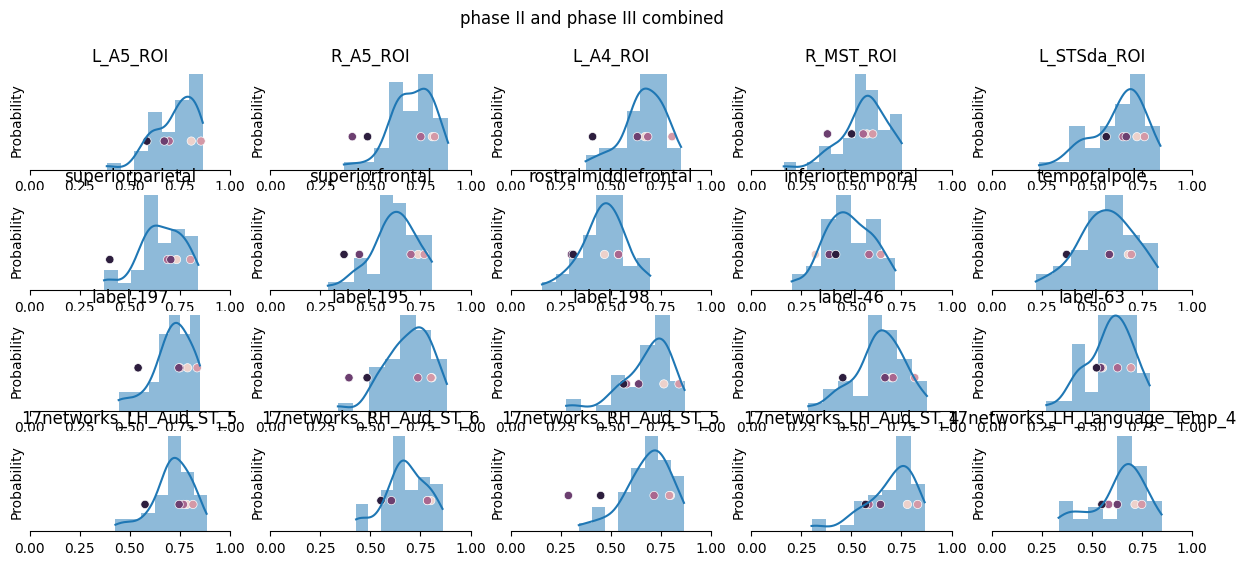

In [15]:
fig, axes = plt.subplots(len(atlases)-1,5,figsize=(15,6))
for i, atlas in enumerate(atlases[1:]):
    # Load labels
    atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
    labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
    labels_R = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
    n_rois = len(labels)
    for r in range(n_rois):
        labels[r+n_rois] = labels_R[r]

    # ind = np.nanargmin(cv[f'{dataset}-{atlas}'])
    # print(f'{atlas}: {labels[ind]}')

    ind = np.argsort(cv[f'{atlas}'])
    print([labels[l] for l in ind[:5]])


    for s in range(5):
        ax = axes[i,s]
        sns.histplot(all_ISC[f'{atlas}'][:,ind[s]], stat='probability', ec=None, kde=True, ax=ax)
        sns.scatterplot(x=patients_ISC[f'{atlas}'][:5,ind[s]], y=0.1, hue=np.arange(5), legend=False, ax=ax)
        # Turn off the box (frame) around the plot
        ax.set_title(labels[ind[s]])
        ax.set_box_aspect(0.5)
        ax.set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

fig.suptitle('phase II and phase III combined')

In [171]:
from scipy.stats import ks_2samp
# ks test accross atlases mean ISC
for i in range(len(atlases)-1):
    for j in range(i+1,len(atlases)-1):
        print(ks_2samp(all_ISC[atlases[i+1]].mean(axis=0),all_ISC[atlases[j+1]].mean(axis=0)))


KstestResult(statistic=0.10584056827150749, pvalue=0.489322564621239, statistic_location=0.17834248060177924, statistic_sign=-1)
KstestResult(statistic=0.058739451911712155, pvalue=0.5016844032109148, statistic_location=0.4094170986770889, statistic_sign=-1)
KstestResult(statistic=0.07145213160715758, pvalue=0.26778449506833046, statistic_location=0.40768559679942873, statistic_sign=-1)
KstestResult(statistic=0.10454868514570007, pvalue=0.4958811347977641, statistic_location=0.17834248060177924, statistic_sign=1)
KstestResult(statistic=0.103909026297086, pvalue=0.5036294967997136, statistic_location=0.09905130483819477, statistic_sign=-1)
KstestResult(statistic=0.04228855721393035, pvalue=0.865504246878499, statistic_location=0.1137032025753179, statistic_sign=-1)


# Dataframe

In [165]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"

df = pd.DataFrame(columns=['atlas', 'ROI_idx', 'ROI_label', 'ISC_con_samp', 'ISC_con_mean', 'ISC_con_std', 'ISC_con_cv', 'ISC_con_nlogcv', 'ISC_con_median', 'ISC_pat_samp', 'ISC_pat_mean', 'AUC'])

for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    # Load controls ISCs
    ISC_con = load_data_loo(file_format)
    # Load patients ISCs
    ISC_pat = load_data_loo(file_format[:-3]+'_patients.h5')

    ISC_con_concat = np.concatenate((ISC_con['L'], ISC_con['R']), axis=1)
    ISC_pat_concat = np.concatenate((ISC_pat['L'], ISC_pat['R']), axis=1)
    for r, roi in enumerate(atlas_labels[atlas]):
        ISC_samp = ISC_con_concat[:,r]
        ISC_pat_samp = ISC_pat_concat[:,r]

        x = np.concatenate((ISC_pat_samp, ISC_samp))
        x[np.isnan(x)] = 0
        y = np.concatenate((-1*np.ones_like(ISC_pat_samp), np.ones_like(ISC_samp)))>0

        df.loc[len(df.index)]= [atlas,r,roi,ISC_samp,ISC_samp.mean(),ISC_samp.std(),ISC_samp.std()/ISC_samp.mean(),-np.log(ISC_samp.std()/ISC_samp.mean()),np.median(ISC_samp),
                                ISC_pat_samp, ISC_pat_samp.mean(axis=0), roc_auc_score(y,x)]
    
    

/tmp/ipykernel_1012731/1589643117.py:23: RuntimeWarning: invalid value encountered in log
  df.loc[len(df.index)]= [atlas,r,roi,ISC_samp,ISC_samp.mean(),ISC_samp.std(),ISC_samp.std()/ISC_samp.mean(),-np.log(ISC_samp.std()/ISC_samp.mean()),np.median(ISC_samp),


In [166]:
df

atlas  ROI_idx                        ROI_label  \
0               Glasser_2016        0                              ???   
1               Glasser_2016        1                         L_V1_ROI   
2               Glasser_2016        2                        L_MST_ROI   
3               Glasser_2016        3                         L_V6_ROI   
4               Glasser_2016        4                         L_V2_ROI   
...                      ...      ...                              ...   
1231  Yan2023_17Networks_400      397        17networks_RH_VisualA_SPL   
1232  Yan2023_17Networks_400      398  17networks_RH_VisualA_TempOcc_1   
1233  Yan2023_17Networks_400      399  17networks_RH_VisualA_TempOcc_2   
1234  Yan2023_17Networks_400      400  17networks_RH_VisualA_TempOcc_3   
1235  Yan2023_17Networks_400      401  17networks_RH_VisualA_TempOcc_4   

                                           ISC_con_samp  ISC_con_mean  \
0     [0.2563059323793156, 0.308304551151033, 0.1605...      0.159971   
1     [0.4549459533441181, 0.3994466966873717, 0.408...      0.299862   
2     [0.6657565864598995, 0.5867427403247141, 0.457...      0.496716   
3     [0.36791262841554506, 0.43462241871521723, 0.4...      0.253518   
4     [0.5087275724705254, 0.3953436795454233, 0.456...      0.334901   
...                                                 ...           ...   
1231  [0.6863652274939224, 0.5392895673193965, 0.498...      0.458692   
1232  [0.6391129470944099, 0.6896882091484681, 0.616...      0.512651   
1233  [0.6146584196802548, 0.577363110979126, 0.6066...      0.552470   
1234  [0.49461151366062134, 0.4383358523130913, 0.43...      0.451866   
1235  [0.6223317378571095, 0.38385872043152686, 0.40...      0.418030   

      ISC_con_std  ISC_con_cv  ISC_con_nlogcv  ISC_con_median  \
0        0.101977    0.637472        0.450244        0.180107   
1        0.127690    0.425830        0.853716        0.304895   
2        0.142760    0.287409        1.246851        0.542796   
3        0.126706    0.499792        0.693563        0.257848   
4        0.133486    0.398583        0.919839        0.338707   
...           ...         ...             ...             ...   
1231     0.123383    0.268990        1.313082        0.444703   
1232     0.122545    0.239042        1.431118        0.525809   
1233     0.118172    0.213897        1.542263        0.560816   
1234     0.134731    0.298165        1.210108        0.447055   
1235     0.143574    0.343454        1.068701        0.435006   

                                           ISC_pat_samp  ISC_pat_mean  \
0     [0.1840679450085089, 0.10375466718602339, 0.08...      0.148507   
1     [0.0840569577756104, 0.511934840953887, 0.2607...      0.277466   
2     [0.3895314039502988, 0.6186579456903013, 0.536...      0.478877   
3     [-0.025656121779965346, 0.17469899084245571, 0...      0.205959   
4     [0.08219649951763754, 0.536868999166292, 0.316...      0.308225   
...                                                 ...           ...   
1231  [0.45769201967019263, 0.5270393051205958, 0.49...      0.420220   
1232  [0.45124408970741814, 0.6187254091003834, 0.56...      0.499587   
1233  [0.4673383530901892, 0.5080222739173265, 0.588...      0.517130   
1234  [0.47984463912001063, 0.4380906960937477, 0.53...      0.452960   
1235  [0.5566657893897234, 0.6750357606237405, 0.471...      0.434747   

           AUC  
0     0.545556  
1     0.534444  
2     0.532778  
3     0.590000  
4     0.543333  
...        ...  
1231  0.534444  
1232  0.506667  
1233  0.561111  
1234  0.478333  
1235  0.442778  

[1236 rows x 12 columns]

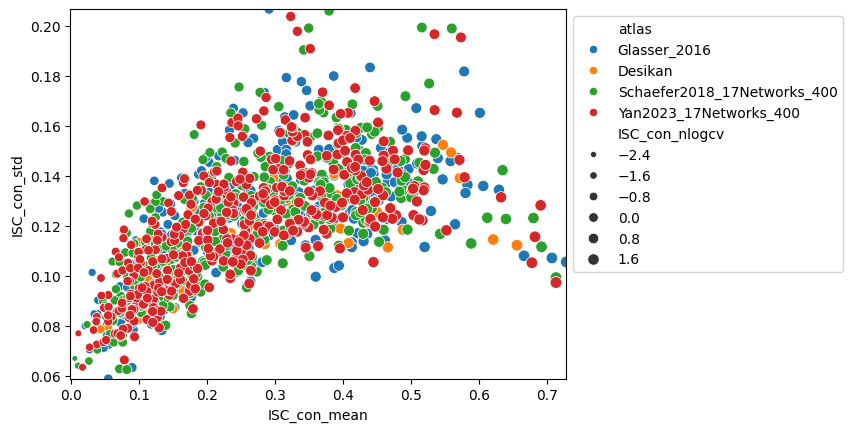

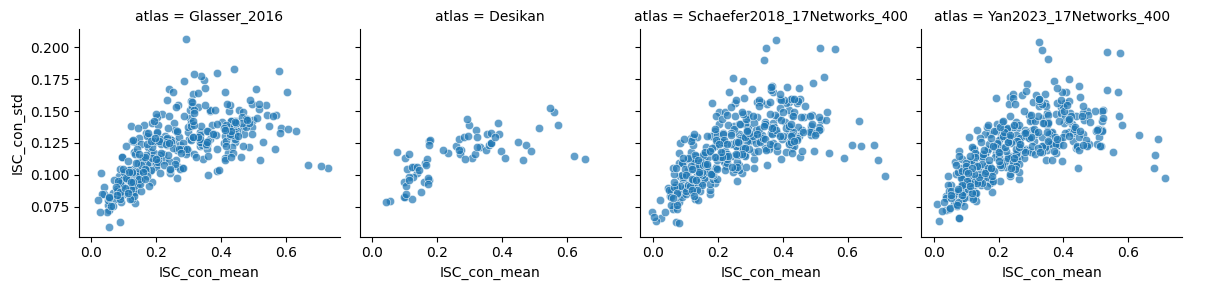

In [170]:
ax = sns.scatterplot(data=df, x='ISC_con_mean', y='ISC_con_std', size='ISC_con_nlogcv', hue='atlas')
# sns.lineplot(x=[0, 1], y=[0, 1])
sns.move_legend(ax, loc='upper left',bbox_to_anchor=(1, 1))
ax.set_xlim([df['ISC_con_mean'].min(), df['ISC_con_mean'].max()])
ax.set_ylim([df['ISC_con_std'].min(), df['ISC_con_std'].max()])

g = sns.FacetGrid(df, col="atlas")
g.map(sns.scatterplot, "ISC_con_mean", "ISC_con_std", alpha=.7)
g.add_legend()

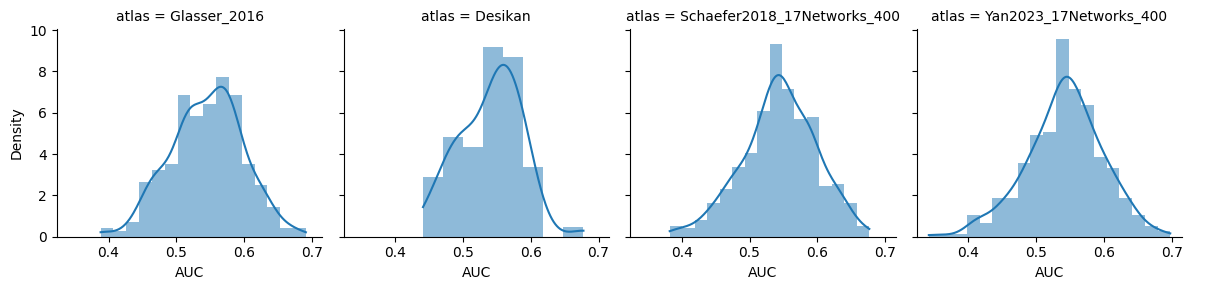

In [164]:
g = sns.FacetGrid(data=df, col='atlas')
g.map(sns.histplot, "AUC", stat='density', ec=None, kde=True)
g.add_legend()

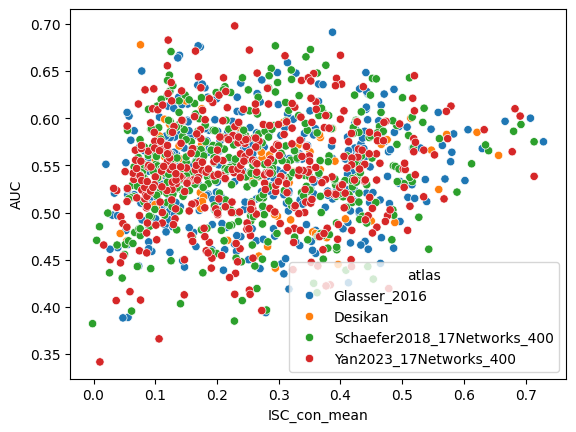

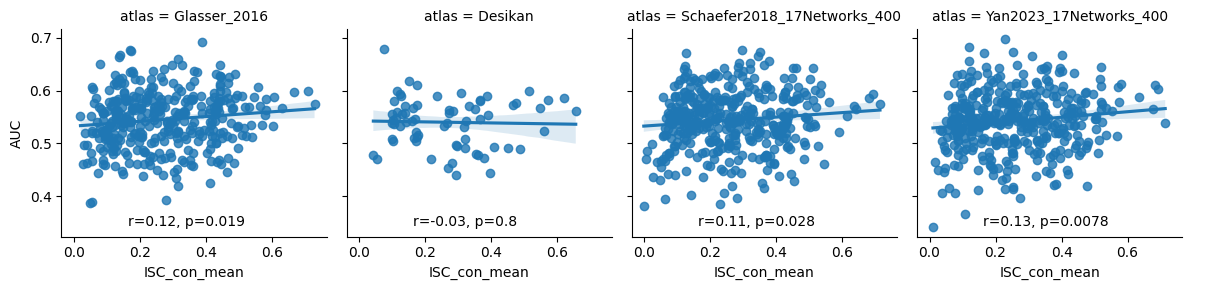

In [154]:
def annotate(x,y, **kws):
    ind = ~(np.isnan(x)|np.isnan(y))
    x = x[ind]
    y = y[ind]
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.text(.25, .05, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

sns.scatterplot(data=df, x='ISC_con_mean', y='AUC', hue='atlas')
g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, "ISC_con_mean", "AUC")
g.map(annotate, "ISC_con_mean", "AUC")
g.add_legend()

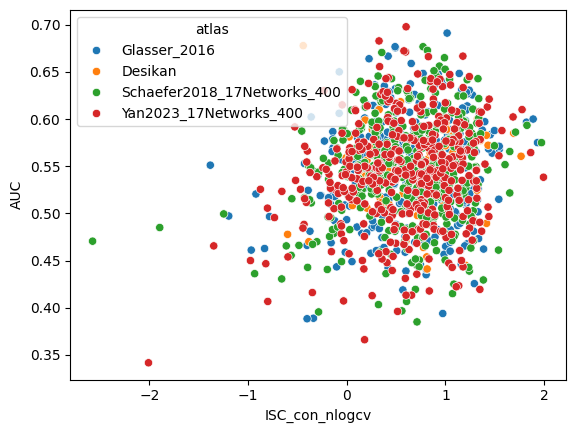

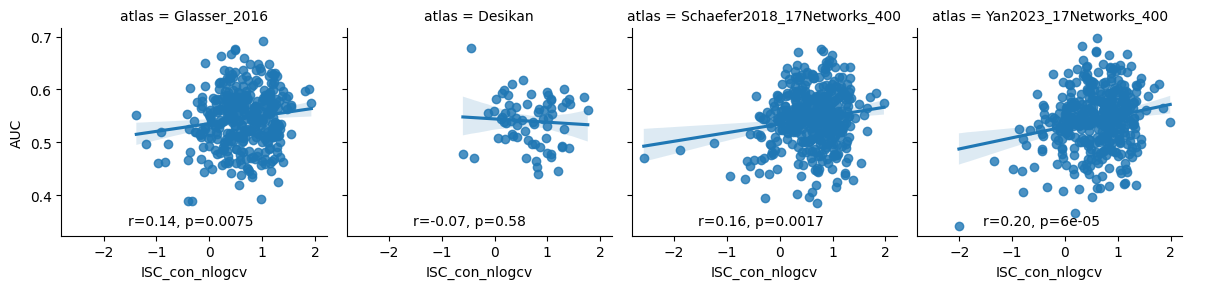

In [169]:
sns.scatterplot(data=df, x='ISC_con_nlogcv', y='AUC', hue='atlas')

g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, "ISC_con_nlogcv", "AUC")
g.map(annotate, "ISC_con_nlogcv", "AUC")
g.add_legend()